In [1]:
# Got my import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import tensorflow as tf



from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from leven import levenshtein

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import time
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TQDM Progress Bar With Pandas Apply Function
tqdm.pandas()

print(f'Tensorflow Version {tf.__version__}')
print(f'Python Version: {sys.version}')


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Tensorflow Version 2.12.0
Python Version: 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]


In [2]:
#  Doesn't work for me
# import tensorflow_addons as tfa


In [3]:
# Read Character to Ordinal Encoding Mapping
with open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)
    
# Ordinal to Character Mapping
ORD2CHAR = {j:i for i,j in CHAR2ORD.items()}
    
# Character to Ordinal Encoding Mapping   
display(pd.Series(CHAR2ORD).to_frame('Ordinal Encoding').T)

,,!,#,$,%,&,',(,),*,...,r,s,t,u,v,w,x,y,z,~
Ordinal Encoding,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58


In [4]:
# If Notebook Is Run By Committing or In Interactive Mode For Development
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
# Verbose Setting during training
VERBOSE = 1 if IS_INTERACTIVE else 2
# Global Random Seed
SEED = 20 # Yay first change
# Number of Frames to resize recording to
N_TARGET_FRAMES = 128
# Global debug flag, takes subset of train
DEBUG = False

N_UNIQUE_CHARACTERS0 = len(CHAR2ORD)
print(f'Original number of unique characters {N_UNIQUE_CHARACTERS0}')
PAD_TOKEN = N_UNIQUE_CHARACTERS0 # This will be the position of Pad Token
SOS_TOKEN = N_UNIQUE_CHARACTERS0 + 1 # This will be the position of the SOS Token
EOS_TOKEN = N_UNIQUE_CHARACTERS0 + 2 # This will be the position of EOS Toekn
N_UNIQUE_CHARACTERS = N_UNIQUE_CHARACTERS0 + 3 # Total number of tokens
print(f'Total number of unique characters {N_UNIQUE_CHARACTERS}')
# Whether to use 30% of data for validation
USE_VAL = True
# Batch Size
BATCH_SIZE = 64
# Number of Epochs to Train for
N_EPOCHS = 20
# Number of Warmup Epochs in Learning Rate Scheduler
N_WARMUP_EPOCHS = 10
# Maximum Learning Rate
LR_MAX = 1e-3
# Weight Decay Ratio as Ratio of Learning Rate
WD_RATIO = 0.05 # Regulaization to penalize large weights
# Length of Phrase + EOS Token
MAX_PHRASE_LENGTH = 31 + 1
# Whether to Train The model
TRAIN_MODEL = True
# Whether to Load Pretrained Weights
LOAD_WEIGHTS = False
# Learning Rate Warmup Method [log,exp]
WARMUP_METHOD = 'exp'

Original number of unique characters 59
Total number of unique characters 62


In [5]:
# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

In [6]:
df = pd.read_parquet('/kaggle/input/asl-fingerspelling/train_landmarks/1019715464.parquet')
df.head()

    

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1975433633,0,0.578892,0.578482,0.582906,0.572686,0.579030,0.582115,0.591430,0.498995,0.595773,...,-0.253687,-0.291687,-0.123892,-0.195255,-0.249135,-0.284375,-0.125050,-0.187797,-0.224827,-0.249662
1975433633,1,0.577563,0.578528,0.582916,0.572760,0.579090,0.582197,0.591687,0.497613,0.596104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975433633,2,0.576181,0.576949,0.581346,0.572293,0.577725,0.581191,0.591550,0.497113,0.596477,...,-0.233556,-0.267114,-0.116145,-0.179053,-0.223861,-0.253004,-0.122090,-0.173169,-0.200727,-0.219106
1975433633,3,0.575575,0.577569,0.581769,0.572443,0.578289,0.581652,0.591728,0.496759,0.596573,...,-0.190909,-0.218471,-0.093956,-0.149982,-0.188452,-0.211573,-0.102759,-0.147642,-0.168562,-0.180578
1975433633,4,0.577907,0.577628,0.582295,0.572930,0.578345,0.581873,0.592467,0.498170,0.597383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.groupby(by=['sequence_id'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161461 entries, 1975433633 to 2008677531
Columns: 1630 entries, frame to z_right_hand_20
dtypes: float32(1629), int16(1)
memory usage: 1004.9 MB


In [9]:
df.shape

(161461, 1630)

In [10]:
MAX_FRAMES = df.loc[df.groupby(by ='sequence_id').size().idxmax()].shape[0]
print(f'Most frames for a single sequence we have in the parqet: {MAX_FRAMES}')

Most frames for a single sequence we have in the parqet: 751


In [11]:
# Read Train DataFrame
if DEBUG:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv').head(5000)
else:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')
    
# Set Train Indexed By sqeuence_id
train_sequence_id = train.set_index('sequence_id')

# Number Of Train Samples
N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

display(train.info())
display(train.head())

N_SAMPLES: 67208
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67208 entries, 0 to 67207
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            67208 non-null  object
 1   file_id         67208 non-null  int64 
 2   sequence_id     67208 non-null  int64 
 3   participant_id  67208 non-null  int64 
 4   phrase          67208 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.6+ MB


None

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


In [12]:
# Get complete file path to file
def get_file_path(path):
    return f'/kaggle/input/asl-fingerspelling/{path}'

train['file_path'] = train['path'].apply(get_file_path)

In [13]:
# Unique Parquet Files
INFERENCE_FILE_PATHS = pd.Series(
        glob.glob('/kaggle/input/aslfr-preprocessing-dataset/train_landmark_subsets/*')
    )

print(f'Found {len(INFERENCE_FILE_PATHS)} Inference Pickle Files')

Found 10 Inference Pickle Files


In [14]:
# # Train/Validation
if USE_VAL:
    # TRAIN
    X_train = np.load('/kaggle/input/asl-spellnet-dataset/X_train.npy')
    y_train = np.load('/kaggle/input/asl-spellnet-dataset/y_train.npy')[:,:MAX_PHRASE_LENGTH]
    N_TRAIN_SAMPLES = len(X_train)
    # VAL
    X_val = np.load('/kaggle/input/asl-spellnet-dataset/X_val.npy')
    y_val = np.load('/kaggle/input/asl-spellnet-dataset/y_val.npy')[:,:MAX_PHRASE_LENGTH]
    N_VAL_SAMPLES = len(X_val)
    # Test
    X_test = np.load('/kaggle/input/asl-spellnet-dataset/X_test.npy')
    y_test = np.load('/kaggle/input/asl-spellnet-dataset/y_test.npy')[:,:MAX_PHRASE_LENGTH]
    N_TEST_SAMPLES = len(X_test)
    # Shapes
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}')
    print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}, y_test shape: {y_test.shape}')


# Train On All Data
else:
    # TRAIN
    X_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/X.npy')
    y_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/y.npy')[:,:MAX_PHRASE_LENGTH]
    N_TRAIN_SAMPLES = len(X_train)
    print(f'X_train shape: {X_train.shape}')

X_train shape: (43369, 128, 164), X_val shape: (9293, 128, 164), X_test shape: (9293, 128, 164)
y_train shape: (43369, 32), y_val shape: (9293, 32), y_test shape: (9293, 32)


In [15]:
# Example Batch For Debugging
N_EXAMPLE_BATCH_SAMPLES = 1024
N_EXAMPLE_BATCH_SAMPLES_SMALL = 32
# Example Batch
X_batch = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES]),
}
y_batch = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES])
# Small Example Batch
X_batch_small = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
}
y_batch_small = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL])

In [16]:
# Read First Parquet File
# example_parquet_df = pd.read_parquet(train['file_path'][0])
example_parquet_df = pd.read_parquet(INFERENCE_FILE_PATHS[0])

# Each parquet file contains 1000 recordings
print(f'# Unique Recording: {example_parquet_df.index.nunique()}')
# Display DataFrame layout
display(example_parquet_df.head())

# Unique Recording: 1000


,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,...,y_face_314,y_face_317,y_face_318,y_face_321,y_face_324,y_face_375,y_face_402,y_face_405,y_face_409,y_face_415
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.551424,0.538415,0.539000,0.546458,0.539715,0.543958,0.538425,0.549351,0.538230,0.540015
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550706,0.538216,0.538723,0.545990,0.539296,0.543357,0.538225,0.548827,0.537376,0.539256
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550613,0.537836,0.538564,0.545949,0.539212,0.543279,0.537961,0.548796,0.537360,0.539332
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.549740,0.536994,0.538449,0.545622,0.539666,0.543694,0.537328,0.548015,0.538301,0.539954
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550614,0.538677,0.540376,0.547104,0.541524,0.545222,0.539203,0.549211,0.539734,0.541707


In [17]:
# Get indices in original dataframe
def get_idxs(df, words_pos, words_neg=[], ret_names=True, idxs_pos=None):
    """
    Returns column indices, or both column indices and names
    Input: dataframe, body_name, words/letters to exclude, get names or not, exact positions to get 
    """
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(example_parquet_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue
                
            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx)
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

In [18]:
# Lips Landmark Face Ids
# #AM we could try adding more face landmarks.
LIPS_LANDMARK_IDXS = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# Landmark Indices for Left/Right hand without z axis in raw data
LEFT_HAND_IDXS0, LEFT_HAND_NAMES0 = get_idxs(example_parquet_df, ['left_hand'], ['z'])
RIGHT_HAND_IDXS0, RIGHT_HAND_NAMES0 = get_idxs(example_parquet_df, ['right_hand'], ['z'])
LIPS_IDXS0, LIPS_NAMES0 = get_idxs(example_parquet_df, ['face'], ['z'], idxs_pos=LIPS_LANDMARK_IDXS)
COLUMNS0 = np.concatenate((LEFT_HAND_NAMES0, RIGHT_HAND_NAMES0, LIPS_NAMES0))
N_COLS0 = len(COLUMNS0)
# Only X/Y axes are used
N_DIMS0 = 2

print(f'N_COLS0: {N_COLS0}')

N_COLS0: 164


In [19]:
# Landmark Indices in subset of dataframe with only COLUMNS selected
LEFT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, LEFT_HAND_NAMES0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, RIGHT_HAND_NAMES0)).squeeze()
LIPS_IDXS = np.argwhere(np.isin(COLUMNS0, LIPS_NAMES0)).squeeze()
HAND_IDXS = np.concatenate((LEFT_HAND_IDXS, RIGHT_HAND_IDXS), axis=0)
N_COLS = N_COLS0
# Only X/Y axes are used
N_DIMS = 2

print(f'N_COLS: {N_COLS}')

N_COLS: 164


In [20]:
# Indices in processed data by axes with only dominant hand
HAND_X_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'x' in name]
    ).squeeze()
HAND_Y_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'y' in name]
    ).squeeze()
# Names in processed data by axes
HAND_X_NAMES = LEFT_HAND_NAMES0[HAND_X_IDXS]
HAND_Y_NAMES = LEFT_HAND_NAMES0[HAND_Y_IDXS]
HAND_X_NAMES.shape, HAND_Y_NAMES.shape

((21,), (21,))

In [21]:
pd.Series(COLUMNS0).to_frame('columns').T

,0,1,2,3,4,5,6,7,8,9,...,154,155,156,157,158,159,160,161,162,163
columns,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,...,y_face_314,y_face_317,y_face_318,y_face_321,y_face_324,y_face_375,y_face_402,y_face_405,y_face_409,y_face_415


In [22]:
# Mean/Standard Deviations of data used for normalizing
MEANS = np.load('/kaggle/input/aslfr-preprocessing-dataset/MEANS.npy').reshape(-1)
STDS = np.load('/kaggle/input/aslfr-preprocessing-dataset/STDS.npy').reshape(-1)

# Tensorflow Preprocessing Layer

In [23]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        self.normalisation_correction = tf.constant(
                    # Add 0.50 to x coordinates of left hand (original right hand) and substract 0.50 of right hand (original left hand)
                     [0.50 if 'x' in name else 0.00 for name in LEFT_HAND_NAMES0],
                dtype=tf.float32,
            )
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0, resize=True):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)
        
        # Hacky
        data = data[None]
        
        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        
        # Pad Zeros
        N_FRAMES = len(data[0])
        if N_FRAMES < N_TARGET_FRAMES:
            data = tf.concat((
                data,
                tf.zeros([1,N_TARGET_FRAMES-N_FRAMES,N_COLS], dtype=tf.float32)
            ), axis=1)
        # Downsample
        data = tf.image.resize(
            data,
            [1, N_TARGET_FRAMES],
            method=tf.image.ResizeMethod.BILINEAR,
        )
        
        # Squeeze Batch Dimension
        data = tf.squeeze(data, axis=[0])
        
        return data
    
preprocess_layer = PreprocessLayer()



In [24]:
# Function To Test Preprocessing Layer
def test_preprocess_layer():
    demo_sequence_id = example_parquet_df.index.unique()[15]
    demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0]
    data = preprocess_layer(demo_raw_data)

    print(f'demo_raw_data shape: {demo_raw_data.shape}')
    print(f'data shape: {data.shape}')
    
    return data
    
if IS_INTERACTIVE:
    data = test_preprocess_layer()

demo_raw_data shape: (159, 164)
data shape: (128, 164)


In [25]:
def get_train_dataset(X, y, batch_size=BATCH_SIZE):
    sample_idxs = np.arange(len(X))
    while True:
        # Get random indices
        random_sample_idxs = np.random.choice(sample_idxs, batch_size)
        
        inputs = {
            'frames': X[random_sample_idxs],
            'phrase': y[random_sample_idxs],
        }
        outputs = y[random_sample_idxs]
        
        yield inputs, outputs

In [26]:
# Train Dataset
train_dataset = get_train_dataset(X_train, y_train)

In [27]:
# Training Steps Per Epoch
TRAIN_STEPS_PER_EPOCH = math.ceil(N_TRAIN_SAMPLES / BATCH_SIZE)
print(f'TRAIN_STEPS_PER_EPOCH: {TRAIN_STEPS_PER_EPOCH}')

TRAIN_STEPS_PER_EPOCH: 678


Calidatioin

In [28]:
# Validation Set
def get_val_dataset(X, y, batch_size=BATCH_SIZE):
    offsets = np.arange(0, len(X), batch_size)
    while True:
        # Iterate over whole validation set
        for offset in offsets:
            inputs = {
                'frames': X[offset:offset+batch_size],
                'phrase': y[offset:offset+batch_size],
            }
            outputs = y[offset:offset+batch_size]

            yield inputs, outputs

In [29]:
# Validation Dataset
print(USE_VAL)
if USE_VAL:
    val_dataset = get_val_dataset(X_val, y_val)
    

True


In [30]:
if USE_VAL:
    N_VAL_STEPS_PER_EPOCH = math.ceil(N_VAL_SAMPLES / BATCH_SIZE)
    print(f'N_VAL_STEPS_PER_EPOCH: {N_VAL_STEPS_PER_EPOCH}')

N_VAL_STEPS_PER_EPOCH: 146


# Model Config

In [31]:

# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# final embedding and transformer embedding size
UNITS_ENCODER = 384
UNITS_DECODER = 256

# Transformer
NUM_BLOCKS_ENCODER = 3
NUM_BLOCKS_DECODER = 2
NUM_HEADS = 4
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
MHA_DROPOUT_RATIO = 0.20
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

# Learning Rate
LEARNING_RATE = 1e-4

# Landmarks Embedding 

In [32]:
# Embeds a landmark using fully connected layers
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        self.supports_masking = True
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU), # Can change activation
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

# Embedding

In [33]:
# Creates embedding for each frame
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        self.supports_masking = True
    
    def build(self, input_shape):
        # Positional embedding for each frame index
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_ENCODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )
        # Embedding layer for Landmarks
        self.dominant_hand_embedding = LandmarkEmbedding(UNITS_ENCODER, 'dominant_hand')

    def call(self, x, training=False):
        # Normalize
        x = tf.where(
                tf.math.equal(x, 0.0),
                0.0,
                (x - MEANS) / STDS,
            )
        # Dominant Hand
        x = self.dominant_hand_embedding(x)
        # Add Positional Encoding
        x = x + self.positional_embedding
        
        return x

# MultiHead Attention Block

In [34]:
# replaced softmax with softmax layer to support masked softmax
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model, num_of_heads, dropout, d_out=None):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads # Can change
        self.wq = [tf.keras.layers.Dense(self.depth//2, use_bias=False) for i in range(num_of_heads)] # depth//2 isn't common, we can try different numbers
        self.wk = [tf.keras.layers.Dense(self.depth//2, use_bias=False) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth//2, use_bias=False) for i in range(num_of_heads)]
        self.softmax = tf.keras.layers.Softmax()
        self.do = tf.keras.layers.Dropout(dropout)
        self.supports_masking = True
        self.wo = tf.keras.layers.Dense(d_model if d_out is None else d_out, use_bias=False)
        
    def call(self, q, k, v, attention_mask=None, training=False):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](q)
            K = self.wk[i](k)
            V = self.wv[i](v)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn, axis=-1)
        multi_head_attention = self.wo(multi_head)
        multi_head_attention = self.do(multi_head_attention, training=training)
        
        return multi_head_attention

In [35]:
class EncoderTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, units, num_heads, mlp_ratio, mha_dropout_ratio, mlp_dropout_ratio, **kwargs):
        super(EncoderTransformerBlock, self).__init__(**kwargs)
        self.layer_norm_1 = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.mha = MultiHeadAttention(units, num_heads, mha_dropout_ratio)
        self.layer_norm_2 = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(units * mlp_ratio, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
            tf.keras.layers.Dropout(mlp_dropout_ratio),
            tf.keras.layers.Dense(units, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
        ])

    def call(self, inputs, attention_mask, training=False):
        x = self.layer_norm_1(inputs + self.mha(inputs, inputs, inputs, attention_mask=attention_mask))
        x = self.layer_norm_2(x + self.mlp(x))
        return x


# Encoder

In [36]:
class Encoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Encoder, self).__init__(name='encoder')
        self.num_blocks = num_blocks
        self.support_masking = True
        self.blocks = [EncoderTransformerBlock(UNITS_ENCODER, NUM_HEADS, MLP_RATIO, MHA_DROPOUT_RATIO, MLP_DROPOUT_RATIO) for _ in range(num_blocks)]

        # Optional Projection to Decoder Dimension
        if UNITS_ENCODER != UNITS_DECODER:
            self.dense_out = tf.keras.layers.Dense(UNITS_DECODER, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False)
            self.apply_dense_out = True
        else:
            self.apply_dense_out = False

    def call(self, x, x_inp, training=False):
        #Attention mask to ignore missing frames
        attention_mask = tf.where(tf.math.reduce_sum(x_inp, axis=[2]) == 0.0, 0.0, 1.0)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.repeat(attention_mask, repeats=N_TARGET_FRAMES, axis=1)
        
        # Iterate input over transformer blocks
        for block in self.blocks:
            x = block(x, attention_mask=attention_mask, training=training)
            
        # Optional Projection to Decoder Dimension
        if self.apply_dense_out:
            x = self.dense_out(x)
    
        return x


# Decoder Transformer


In [37]:
class DecoderTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, units, num_heads, mlp_ratio, mha_dropout_ratio, mlp_dropout_ratio, **kwargs):
        super(DecoderTransformerBlock, self).__init__(**kwargs)
        self.layer_norm_1 = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.mha = MultiHeadAttention(units, num_heads, mha_dropout_ratio)
        self.layer_norm_2 = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(units * mlp_ratio, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
            tf.keras.layers.Dropout(mlp_dropout_ratio),
            tf.keras.layers.Dense(units, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
        ])

    def call(self, inputs, encoder_outputs, attention_mask, training=False):
        x = self.layer_norm_1(inputs + self.mha(inputs, encoder_outputs, encoder_outputs, attention_mask=attention_mask))
        x = self.layer_norm_2(x + self.mlp(x))
        return x
    

# Decoder

In [38]:
self_attention_mask =tf.ones((N_TARGET_FRAMES, N_TARGET_FRAMES))
self_attention_mask = tf.linalg.band_part(self_attention_mask, -1, 0)
tf.cast(self_attention_mask, tf.float32)

<tf.Tensor: shape=(128, 128), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>

In [39]:
class Decoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Decoder, self).__init__(name='decoder')
        self.num_blocks = num_blocks
        self.supports_masking = True

        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_DECODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )

        # Character Embedding
        self.char_emb = tf.keras.layers.Embedding(N_UNIQUE_CHARACTERS, UNITS_DECODER, embeddings_initializer=INIT_ZEROS)
        
        # Positional Encoder MHA
        self.pos_emb_mha = MultiHeadAttention(UNITS_DECODER, NUM_HEADS, MHA_DROPOUT_RATIO)
        self.pos_emb_ln = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

        # Decoder Blocks
        self.blocks = [DecoderTransformerBlock(UNITS_DECODER, NUM_HEADS, MLP_RATIO, MHA_DROPOUT_RATIO,MLP_DROPOUT_RATIO) for _ in range(num_blocks)]

    def get_causal_attention_mask(self, B):
        # My version of the mask AM
        ones = tf.ones((N_TARGET_FRAMES, N_TARGET_FRAMES))
        mask = tf.linalg.band_part(ones, 0, -1)  
        mask = tf.transpose(mask)
        mask = tf.expand_dims(mask, axis=0)
        mask = tf.tile(mask, [B, 1, 1])
        mask = tf.cast(mask, tf.float32)
        return mask

    def call(self, encoder_outputs, phrase, training=False):
        # Batch Size
        B = tf.shape(encoder_outputs)[0]
        # Cast to INT32
        phrase = tf.cast(phrase, tf.int32)
        # Prepend SOS Token
        phrase = tf.pad(phrase, [[0,0], [1,0]], constant_values=SOS_TOKEN, name='prepend_sos_token')
        # Pad With PAD Token
        phrase = tf.pad(phrase, [[0,0], [0,N_TARGET_FRAMES-MAX_PHRASE_LENGTH-1]], constant_values=PAD_TOKEN, name='append_pad_token')
        # Causal Mask
        causal_mask = self.get_causal_attention_mask(B)
        # Positional Embedding
        x = self.positional_embedding + self.char_emb(phrase)
        # Causal Attention
        x = self.pos_emb_ln(x + self.pos_emb_mha(x, x, x, attention_mask=causal_mask))
        # Iterate input over causal_masktransformer blocks
        for block in self.blocks:
            x = block(x, encoder_outputs, causal_mask, training=training)
        # Slice 31 Characters
        x = tf.slice(x, [0, 0, 0], [-1, MAX_PHRASE_LENGTH, -1])
        return x


# Non Pad/SOS/EOS Token Accuracy

# Sparse Categorical Crossentropy With Label Smoothing

In [40]:
# TopK accuracy for multi dimensional output
class TopKAccuracy(tf.keras.metrics.Metric):
    def __init__(self, k, **kwargs):
        super(TopKAccuracy, self).__init__(name=f'top{k}acc', **kwargs)
        self.top_k_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=k)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1, N_UNIQUE_CHARACTERS])
        character_idxs = tf.where(y_true < N_UNIQUE_CHARACTERS0)
        y_true = tf.gather(y_true, character_idxs, axis=0)
        y_pred = tf.gather(y_pred, character_idxs, axis=0)
        self.top_k_acc.update_state(y_true, y_pred)

    def result(self):
        return self.top_k_acc.result()
    
    def reset_state(self):
        self.top_k_acc.reset_state()

In [41]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy

class CustomSCCEWithLS(tf.keras.losses.Loss):
    def __init__(self, loss_weights, pad_token=PAD_TOKEN, n_unique_characters=N_UNIQUE_CHARACTERS, label_smoothing=0.25, **kwargs):
        super().__init__(**kwargs)
        self.loss_weights = loss_weights
        self.pad_token = pad_token
        self.n_unique_characters = n_unique_characters
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        # Filter Pad Tokens
        idxs = tf.where(y_true != self.pad_token)
        y_true = tf.gather_nd(y_true, idxs)
        y_pred = tf.gather_nd(y_pred, idxs)
        # One Hot Encode Sparsely Encoded Target Sign
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, self.n_unique_characters, axis=1)
        # Apply loss_weights
        y_true = y_true * self.loss_weights
        # Categorical Crossentropy with native label smoothing support
        loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=self.label_smoothing, from_logits=True)
        loss = tf.math.reduce_mean(loss)
        return loss

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "loss_weights": self.loss_weights.tolist(), "pad_token": self.pad_token, 
                "n_unique_characters": self.n_unique_characters, "label_smoothing": self.label_smoothing}


# Model

In [42]:
def get_model():
    # Inputs
    frames_inp = tf.keras.layers.Input([N_TARGET_FRAMES, N_COLS], dtype=tf.float32, name='frames')
    phrase_inp = tf.keras.layers.Input([MAX_PHRASE_LENGTH], dtype=tf.int32, name='phrase')
    # Frames
    x = frames_inp
    
    # Masking 
    x = tf.keras.layers.Masking(mask_value=0.0, input_shape=(N_TARGET_FRAMES, N_COLS))(x)
    
    # Embedding
    x = Embedding()(x)
    
    # Encoder Transformer Blocks
    x = Encoder(NUM_BLOCKS_ENCODER)(x, frames_inp)
    
    # Decoder
    x = Decoder(NUM_BLOCKS_DECODER)(x, phrase_inp)
    
    # Classifier
    x = tf.keras.Sequential([
        # Dropout
        tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO),
        # Output Neurons
        tf.keras.layers.Dense(N_UNIQUE_CHARACTERS, activation=tf.keras.activations.linear, kernel_initializer=INIT_HE_UNIFORM, use_bias=False), # can changes initializer/activation
    ], name='classifier')(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames_inp, phrase_inp], outputs=outputs)
    
    #optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # We should try different optimizers with learning rate scheduler
    
    # Create Initial Loss Weights All Set To 1
    loss_weights_tensor = tf.ones([N_UNIQUE_CHARACTERS], dtype=tf.float32)
    # Set Loss Weight Of Pad Token To 0
    loss_weights_tensor = tf.tensor_scatter_nd_update(loss_weights_tensor, [[PAD_TOKEN]], [0])

    # Convert the tensor to a numpy array
    loss_weights = loss_weights_tensor.numpy()

    # Categorical Crossentropy Loss With Label Smoothing
#     loss = scce_with_ls
    loss = CustomSCCEWithLS(loss_weights)

    metrics = [
        TopKAccuracy(1),
        TopKAccuracy(5),
    ]
    
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics,
        loss_weights=loss_weights,
    )
    
    return model

In [43]:
for k, v in X_batch.items():
    print(f'{k}: {v.shape}')

frames: (1024, 128, 164)
phrase: (1024, 32)


In [44]:
tf.keras.backend.clear_session()

model = get_model()

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 128, 164)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 128, 164)     0           ['frames[0][0]']                 
                                                                                                  
 embedding (Embedding)          (None, 128, 384)     259968      ['masking[0][0]']                
                                                                                                  
 encoder (Encoder)              (None, 128, 256)     2757120     ['embedding[0][0]',              
                                                                  'frames[0][0]']             

In [46]:
model.summary(expand_nested=True, show_trainable=True,)

Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 frames (InputLayer)            [(None, 128, 164)]   0           []                               Y          
                                                                                                             
 masking (Masking)              (None, 128, 164)     0           ['frames[0][0]']                 Y          
                                                                                                             
 embedding (Embedding)          (None, 128, 384)     259968      ['masking[0][0]']                Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| dominant_hand_embedding (Landm  multiple          210816      []                               Y       

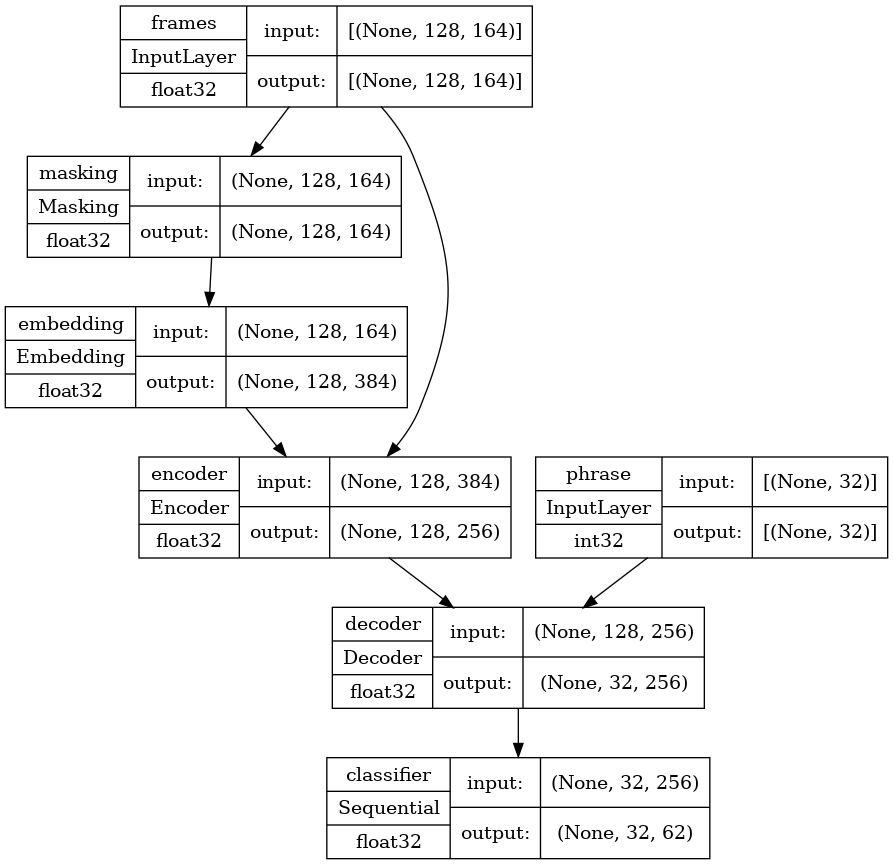

In [47]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, show_layer_activations=True)

In [48]:
 history = model.fit(
            x=train_dataset,
            steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
            epochs=N_EPOCHS,
            validation_data=val_dataset,
            validation_steps=N_VAL_STEPS_PER_EPOCH,
            verbose = VERBOSE,
        )

Epoch 1/20
678/678 [==============================] - 130s 133ms/step - loss: 3.3841 - top1acc: 0.1910 - top5acc: 0.5176 - val_loss: 3.1218 - val_top1acc: 0.2116 - val_top5acc: 0.5956
Epoch 2/20
678/678 [==============================] - 81s 119ms/step - loss: 3.2219 - top1acc: 0.2340 - top5acc: 0.5827 - val_loss: 3.0363 - val_top1acc: 0.2680 - val_top5acc: 0.6505
Epoch 3/20
678/678 [==============================] - 81s 120ms/step - loss: 3.1384 - top1acc: 0.2646 - top5acc: 0.6300 - val_loss: 2.9832 - val_top1acc: 0.2929 - val_top5acc: 0.6981
Epoch 4/20
678/678 [==============================] - 85s 125ms/step - loss: 3.0779 - top1acc: 0.2902 - top5acc: 0.6632 - val_loss: 2.9263 - val_top1acc: 0.3246 - val_top5acc: 0.7288
Epoch 5/20
678/678 [==============================] - 85s 125ms/step - loss: 3.0154 - top1acc: 0.3182 - top5acc: 0.6929 - val_loss: 2.8589 - val_top1acc: 0.3617 - val_top5acc: 0.7618
Epoch 6/20
678/678 [==============================] - 81s 119ms/step - loss: 2.9476 

In [49]:
model.save_weights('model.h5')


In [50]:
# Save history
train_loss = history.history['loss']
train_top1acc = history.history['top1acc']
train_top5acc = history.history['top5acc']

val_loss = history.history['val_loss']
val_top1acc = history.history['val_top1acc']
val_top5acc = history.history['val_top5acc']


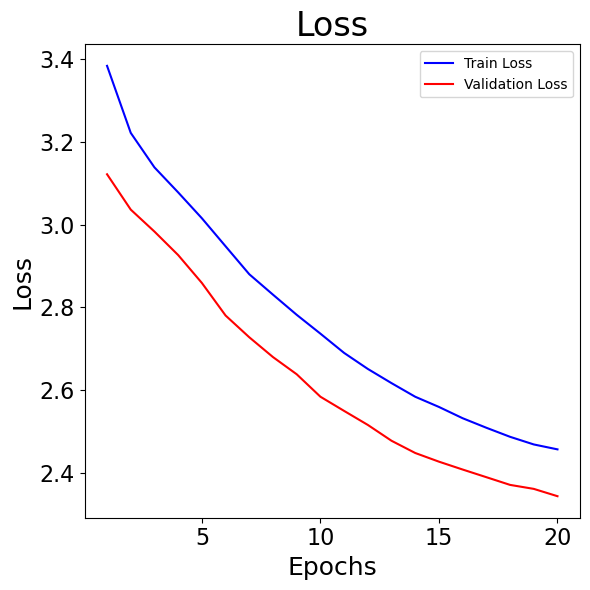

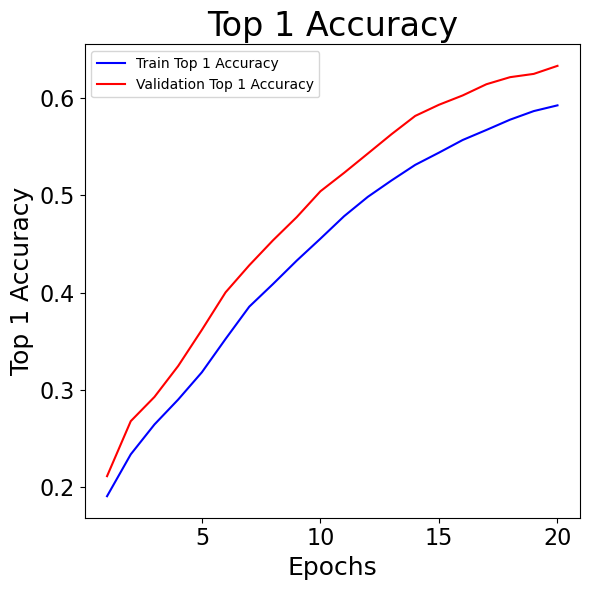

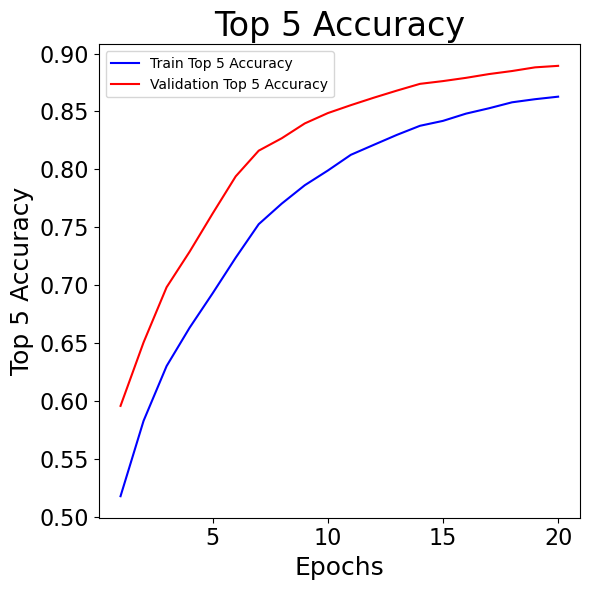

In [51]:


epochs = range(1, len(val_loss) + 1)

# Plotting Loss
plt.figure(figsize=(6,6))
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show();

# Plotting Accuracy
plt.figure(figsize=(6,6))
plt.plot(epochs, train_top1acc, 'b', label='Train Top 1 Accuracy')
plt.plot(epochs, val_top1acc, 'r', label='Validation Top 1 Accuracy')
plt.title('Top 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top 1 Accuracy')
plt.legend()
plt.tight_layout()

plt.show();

plt.figure(figsize=(6,6))
plt.plot(epochs, train_top5acc, 'b', label='Train Top 5 Accuracy')
plt.plot(epochs, val_top5acc, 'r', label='Validation Top 5 Accuracy')
plt.title('Top 5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top 5 Accuracy')
plt.legend()
plt.tight_layout()

plt.show();





In [52]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

In [53]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

# Prediction 

In [54]:
# Output Predictions to string
def outputs2phrase(outputs):
    if outputs.ndim == 2:
        outputs = np.argmax(outputs, axis=1)
    
    return ''.join([ORD2CHAR.get(s, '') for s in outputs])

# Parallelization of Prediction

In [179]:
@tf.function()
def predict_phrase(batch_frames):
    batch_frames = tf.convert_to_tensor(batch_frames)
    phrase = tf.fill([batch_frames.shape[0], MAX_PHRASE_LENGTH], PAD_TOKEN)
    phrase = tf.cast(phrase, tf.int32) # Cast phrase to int32 initially
    for idx in tf.range(MAX_PHRASE_LENGTH):
        # Predict Next Token
        outputs = model({
            'frames': batch_frames,
            'phrase': phrase,
        })
        
        phrase = tf.where(
            tf.range(MAX_PHRASE_LENGTH)[None, :] < idx + 1,
            tf.argmax(outputs, axis=-1, output_type=tf.int32),
            phrase,
        )
    # one-hot encode the outputs
    outputs_one_hot = tf.one_hot(phrase, depth=N_UNIQUE_CHARACTERS)
    return outputs_one_hot


In [181]:
def get_ld_test(batch_size):
    LD_TEST = []
    for idx in tqdm(range(0, len(X_test), batch_size)):
        batch_frames = X_test[idx:idx+batch_size]
        true_phrases = y_test[idx:idx+batch_size]

        # Predict Phrases and Convert to Strings
        pred_phrases = predict_phrase(batch_frames).numpy()
        pred_phrases = [outputs2phrase(p) for p in pred_phrases]

        # True Phrases Ordinal to Strings
        true_phrases = [outputs2phrase(t) for t in true_phrases]

        # Add Levenshtein Distances
        LD_TEST.extend([{
            'phrase_true': true_phrase,
            'phrase_pred': pred_phrase,
            'levenshtein_distance': levenshtein(pred_phrase, true_phrase),
        } for true_phrase, pred_phrase in zip(true_phrases, pred_phrases)])

    # Convert to DataFrame
    LD_TEST_DF = pd.DataFrame(LD_TEST)
    
    return LD_TEST_DF

In [182]:
LD_TEST_DF = get_ld_test(512)

# Display Errors
display(LD_TEST_DF.head(30))

  0%|          | 0/19 [00:00<?, ?it/s]

,phrase_true,phrase_pred,levenshtein_distance
0,425 andrus loop,2442 nandre solop,8
1,3130 oak stream dr,330 remar mer,11
2,620 new hampshire 6th cutoff,www.hahireweh.com/hactof,21
3,+39-4218-2683-13,+39-428-268-32-132,4
4,666-818-8052,www.818-8052.52,7
5,3242 pine place road,3242 eaco road,7
6,54 malgren,54 malgere,2
7,402-210-8595,402-210-8595,0
8,2130 altrui place,130 maltte parke,8
9,+374-6400-15,+43-41-43-419-43-241,14


In [184]:
LD_TEST_DF['levenshtein_distance'].describe()

count    9293.000000
mean        7.852039
std         5.269650
min         0.000000
25%         4.000000
50%         7.000000
75%        11.000000
max        28.000000
Name: levenshtein_distance, dtype: float64

In [185]:
LD_TEST_DF['levenshtein_distance'].value_counts()

4     788
5     771
6     769
7     756
8     747
3     671
2     644
9     559
10    476
1     422
11    413
12    339
13    296
0     265
14    262
15    212
16    178
17    151
18    131
19    102
20     80
21     70
22     65
23     60
24     22
25     19
27     13
26     11
28      1
Name: levenshtein_distance, dtype: int64

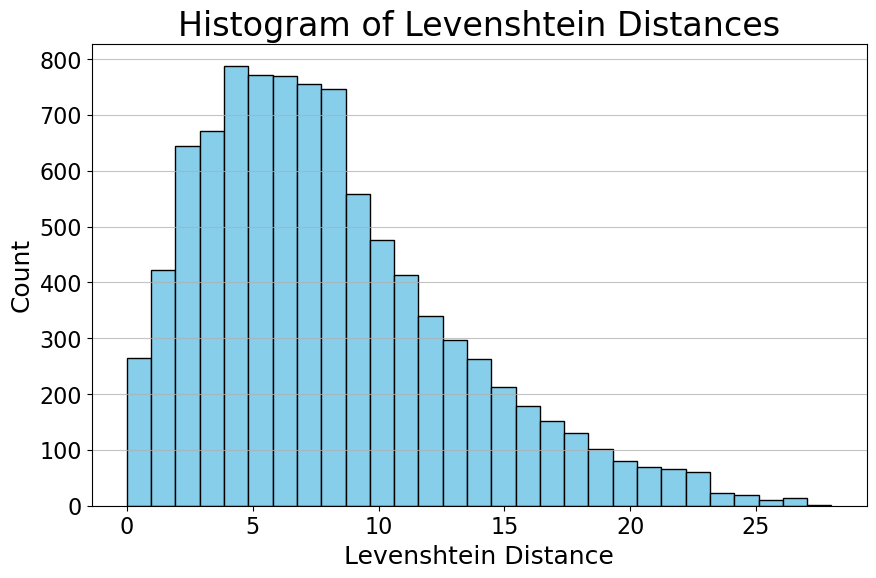

In [186]:
plt.figure(figsize=(10,6))  
plt.hist(LD_TEST_DF['levenshtein_distance'], bins=29, color='skyblue', edgecolor='black')
plt.title('Histogram of Levenshtein Distances')  
plt.xlabel('Levenshtein Distance')  
plt.ylabel('Count')  
plt.grid(axis='y', alpha=0.75)  
plt.show();

In [61]:
LD_TEST_DF['levenshtein_distance'].mean(), LD_TEST_DF['levenshtein_distance'].std()

(7.85203916926719, 5.269650450392536)

In [62]:
LD_TEST_DF.to_csv('LD_TEST_DF')

# Saving the model


In [63]:
# TFLite model for submission
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
    
    @tf.function(jit_compile=True)
    def encoder(self, x, frames_inp):
        x = self.model.get_layer('embedding')(x)
        x = self.model.get_layer('encoder')(x, frames_inp)
        
        return x
        
    @tf.function(jit_compile=True)
    def decoder(self, x, phrase_inp):
        x = self.model.get_layer('decoder')(x, phrase_inp)
        x = self.model.get_layer('classifier')(x)
        
        return x
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_COLS0], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Number Of Input Frames
        N_INPUT_FRAMES = tf.shape(inputs)[0]
        # Preprocess Data
        frames_inp = self.preprocess_layer(inputs)        
        # Add Batch Dimension
        frames_inp = tf.expand_dims(frames_inp, axis=0)
        # Get Encoding
        encoding = self.encoder(frames_inp, frames_inp)
        # Make Prediction
        phrase = tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN)
        # Predict One Token At A Time
        stop = False
        for idx in tf.range(MAX_PHRASE_LENGTH):
            # Cast phrase to int8
            phrase = tf.cast(phrase, tf.int8)
            # If EOS token is predicted, stop predicting
            outputs = tf.cond(
                stop,
                lambda: tf.one_hot(tf.cast(phrase, tf.int32), N_UNIQUE_CHARACTERS),
                lambda: self.decoder(encoding, phrase)
            )
            # Add predicted token to input phrase
            phrase = tf.cast(phrase, tf.int32)
            # Replcae PAD token with predicted token up to idx
            phrase = tf.where(
                tf.range(MAX_PHRASE_LENGTH) < idx + 1,
                tf.argmax(outputs, axis=2, output_type=tf.int32),
                phrase,
            )
            # Predicted Token
            predicted_token = phrase[0,idx]
            # If EOS (End Of Sentence) token is predicted stop
            if not stop:
                stop = predicted_token == EOS_TOKEN
            
        # Squeeze outputs
        outputs = tf.squeeze(phrase, axis=0)
        outputs = tf.one_hot(outputs, N_UNIQUE_CHARACTERS)
            
        # Return a dictionary with the output tensor
        return {'outputs': outputs }

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)

# Sanity Check
# demo_sequence_id = 1816796431
demo_sequence_id = example_parquet_df.index.unique()[0]
demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0].values
demo_phrase_true = train_sequence_id.loc[demo_sequence_id, 'phrase']
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)['outputs'].numpy()
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
print(f'demo_outputs phrase decoded: {outputs2phrase(demo_output)}')
print(f'phrase true: {demo_phrase_true}')

demo_raw_data shape: (123, 164), dtype: float32
demo_output shape: (32, 62), dtype: float32
demo_outputs phrase decoded: 33 creek house
phrase true: 3 creekhouse


# Attempt to 

In [64]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [65]:
# Add selected_columns json to only select specific columns from input frames
with open('inference_args.json', 'w') as f:
     json.dump({ 'selected_columns': COLUMNS0.tolist() }, f)

In [66]:
# Zip Model
!zip submission.zip /kaggle/working/model.tflite /kaggle/working/inference_args.json

  adding: kaggle/working/model.tflite (deflated 9%)
  adding: kaggle/working/inference_args.json (deflated 83%)
